# STA208 Final Project

## Predicting Marine Organism Conservation Status

_________________
__Author:__ Evan Batzer 

__Date:__ 6/2/2020

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
from os import path
from plotnine import *
from matplotlib import pyplot as plt
import copy
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

### 0. Background

Biodiversity loss is a major focus of environmental management in the 21st century -- extinctions of plant and animal species is estimated to be 10 - 100 times greater than in the past 10 million years, largely as a function of human activity. 

Several organizations have attempted to provide global-level databases to help monitor and predict biodiversity loss. Chief among these is the __IUCN__, the International Union for the Conservation of Nature, which publishes a continually updating list of species known as the _Red List_.

![IUCN](../images/IUCN_logo.png)

The _Red List_ is established as a useful tool for conservation decision-making, but is difficult to maintain. There are estimated to be roughly 8.7 Million species on the planet, each of which must be assessed by a panel of experts to be included on the _Red List_. 

Species are given a conservation designation ranging from "Least Concern" to "Extinct".

![IUCN_labels](../images/IUCN_classes.png)

However, species given conservation designations on the _Red List_ often share similar characteristics -- size, reproductive capacity, human use for agriculture, etc. These features may be effective classifiers of species with known conservation designations and may help speed the process of generating and updating IUCN databases.

__Core Question:__ How well can conservation status be classified by species characteristics?

### 1. Assembling Dataset

__Querying FishBase API__

FishBase is a global database containing information on the characteristics and distribution of roughly 34,000 fish species. These characteristics are thought to be good predictors of species IUCN status. Large, slow-growing species, for example, may be more likely to go extinct than smaller, faster-growing species with limited commercial value.

Data is open access and generally well-documented, but provided at several levels of organization. Because IUCN categorization is made at the species level, meaningful features must be extracted, cleaned, and aggregated at an appropriate scale.

Rather than containing information on a species-by-species basis, the ecosystem table contains features that are organized by different habitats. Because models will be constructed at the species level (not subspecies or individual habitat), I aggregate these based on metric. Certain features are binary (present in freshwater/saltwater), so are converted to one-hot labels and summed per species -- some fish may be present in both types of water, for example. Others are summed or averaged, such as total range or average depth. Tables may also contain considerable overlap in columns, particularly related to error checking or source material. 

See `../code/` for more detail on these data extraction functions. 

In [2]:
if not path.exists('../data/fishbase_features.csv'):
    !python ../code/extract_fishbase.py

__Retrieving IUCN Redlist labels__

While the IUCN claims to provide a developer API, attempts to retrieve a token were unsuccessful. As a result, this analysis will be performed using an older version of the IUCN dataset from 2013, hosted as part of a public data repository.

In [3]:
if not path.exists('../data/IUCN_subset.csv'):
    !python ../code/extract_IUCN.py

__Joining Tables__

In [4]:
# Reading datasets generated in previous step
features = pd.read_csv("../data/fishbase_features.csv", index_col =1)
iucn_labels = pd.read_csv("../data/IUCN_subset.csv",  index_col = 1)

# Merging (left join on FishBase data)
full_df = pd.merge(features, iucn_labels.iloc[:,3:],  
         how='left', 
         left_on=['Genus', 'Species'], 
         right_on = ['Genus', 'Species'])

# Removing NAs and standaridizing labels
data_labelled = full_df[full_df["Red List status"].notna()]

# Removing species that are "endangered" or "extinct in the wild"
data_labelled = data_labelled[~data_labelled["Red List status"].isin(["EX", "EW"])]

# The data I am using is a few years old, and contains secondary categories between 
# LC - "Least Concern" and NT - "Near Threatened" -- "LR/lc" and "LR/nt". 
# There are relatively few observations of this class, so I'll just lump them into the LC class.
data_labelled["Red List status"] = data_labelled["Red List status"].str.replace("LR.+", "LC")
data_labelled["Red List status"] = pd.Categorical(data_labelled["Red List status"],
               categories = ["LC", "NT", "VU", "EN", "CR"],
              ordered=True)



# Outputting labelled dataset
data_labelled.to_csv("../data/data_labelled.csv")

data_labelled.shape

(9203, 76)

__Visualizing class distribution__

Note that classes are distributed in a way that is unbalanced -- a majority of species are given an "LC" designation, referring to species of "least concern" who are not a priority for conservation action.

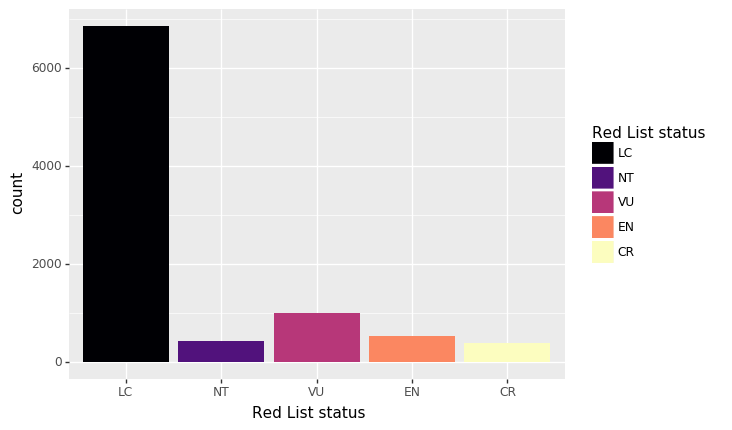

<ggplot: (-9223371877503373132)>

In [5]:
(ggplot(data_labelled,
       aes(x = 'Red List status',
          fill = 'Red List status')) + 
 geom_bar() +
scale_fill_cmap_d("magma"))

### 2. Data Exploration - Sparsity

While data available on Fishbase contain a wealth of information on different characteristics, many features are difficult to assess for many species. As a result, the features of this database may be quite sparse.

Total column sparsity ranges between 0 and ~97% missing, for certain variables:

In [6]:
feature_sparsity = full_df.isnull().astype(int).sum() / full_df.shape[0]
feature_sparsity.sort_values()

Genus                        0.000000
Aquarium_public aquariums    0.000000
Aquarium_show aquarium       0.000000
Aquaculture_commercial       0.000000
Aquaculture_experimental     0.000000
                               ...   
AverageDepth                 0.726283
Red List status              0.730126
Weight                       0.936201
Length_Maturity              0.942927
Age_Maturity                 0.970532
Length: 76, dtype: float64

__Is sparsity correlated with assessment?__

Because the IUCN requires sufficient data for its expert panel to make a recommendation, species that are rare or difficult to study may be less likely to be assessed. 

Here, I group observations based on whether they have an associated IUCN status tag. "Diff Missingness" calculates the difference in the proportion of observations missing (by feature) between species that have been assessed and those that have not.

In [7]:
iucn_grps = full_df.groupby(1 - full_df["Red List status"].isnull())
label_summary = iucn_grps.apply(lambda column: column.isnull().astype(int).sum() / len(column)).drop("Red List status", axis = 1)
label_summary.diff().drop(0).transpose().sort_values(1).rename(columns={1: "Diff Missingness"})

Red List status,Diff Missingness
brackish,-0.304298
Area,-0.304298
boreal,-0.304298
temperate,-0.304298
polar,-0.304298
...,...
Aquaculture_commercial,0.000000
Aquarium_show aquarium,0.000000
Aquarium_public aquariums,0.000000
Bait_never/rarely,0.000000


Because of one-hot encoding, certain qualitative features are represented by more than one column. For this visualization, I take the first column of each set of features with identical patterns in missingness.

There is a general, if slight, increase in the proportion of missing observations for species without assessment (X = 0) relative to those that have been assessed (X = 1). However, these differences appear most pronounced for features with intermediate levels of sparsity, such as "brackish" (habitat preference), "abyssopelagic" (habitat depth type), and "Average Depth". Others, such as minimum length of age of maturity, are sparse for both classes, while species length and "genus" (phylogenetic information) are represented completely.  

Text(0, 0.5, 'Proportion observations missing')

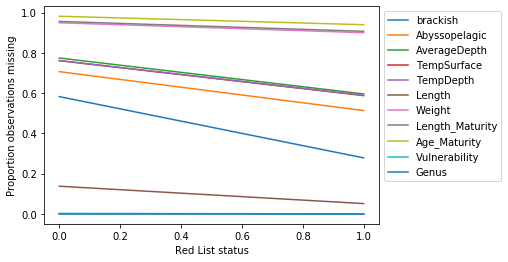

In [8]:
miss_cols = label_summary.diff().drop(0).transpose().sort_values(1).drop_duplicates().index
ax = label_summary[miss_cols].plot()
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Proportion observations missing")

In [9]:
label_summary.index = ["Not Assessed", "Assessed"]
label_summary[miss_cols]

,brackish,Abyssopelagic,AverageDepth,TempSurface,TempDepth,Length,Weight,Length_Maturity,Age_Maturity,Vulnerability,Genus
Not Assessed,0.582675,0.706628,0.774388,0.761107,0.762104,0.137553,0.949549,0.95617,0.981854,0.002433,0.0
Assessed,0.278377,0.513379,0.596137,0.587721,0.589340,0.051360,0.900086,0.90710,0.939901,0.000000,0.0


__Is sparsity correlated with assessment class?__

Sparsity may also be associated with assessment category. Here, I repeat the above focusing on those species that are given IUCN assessment labels.

In [10]:
iucn_grps = data_labelled.groupby(data_labelled["Red List status"])
label_summary = iucn_grps.apply(lambda column: column.isnull().astype(int).sum() / len(column)).drop("Red List status", axis = 1)
label_summary.transpose()

Red List status,LC,NT,VU,EN,CR
Genus,0.000000,0.000000,0.000000,0.000000,0.000000
SpecCode,0.000000,0.000000,0.000000,0.000000,0.000000
Species,0.000000,0.000000,0.000000,0.000000,0.000000
Family,0.000000,0.000000,0.000000,0.000000,0.000000
Order,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
boreal,0.251241,0.272300,0.356789,0.396262,0.386423
Area,0.251241,0.272300,0.356789,0.396262,0.386423
AverageDepth,0.575036,0.544601,0.667988,0.706542,0.665796
TempSurface,0.567737,0.535211,0.655104,0.691589,0.655352


In [11]:
label_summary.transpose().drop_duplicates()[["LC", "NT", "VU", "EN", "CR"]]

Red List status,LC,NT,VU,EN,CR
Genus,0.000000,0.000000,0.000000,0.000000,0.000000
Length,0.042190,0.035211,0.073340,0.087850,0.107050
Weight,0.903212,0.814554,0.913776,0.914019,0.877285
Neritic,0.487299,0.497653,0.616452,0.601869,0.553525
Age_Maturity,0.945693,0.899061,0.929633,0.921495,0.929504
Length_Maturity,0.918978,0.734742,0.884044,0.912150,0.926893
Speccode,0.251241,0.272300,0.356789,0.396262,0.386423
AverageDepth,0.575036,0.544601,0.667988,0.706542,0.665796
TempSurface,0.567737,0.535211,0.655104,0.691589,0.655352
TempDepth,0.569489,0.537559,0.657086,0.691589,0.655352


In [12]:
label_summary = label_summary.reindex(["LC", "NT", "VU", "EN", "CR"])

Generally, it seems that sparsity for certain variables may increase as Red List status codes move from "Least Concern" to "Critically Endangered", though these patterns are not particularly well-defined.

Text(0, 0.5, 'Proportion observations missing')

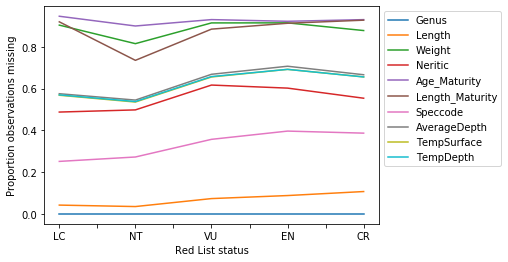

In [13]:
miss_cols = label_summary.transpose().drop_duplicates().index
ax = label_summary[miss_cols].plot()
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Proportion observations missing")

__Filtering features with excess sparsity__

To avoid introducing too much bias in imputation, I filter columns with excess sparsity -- dropping features with greater than ~ 50% of observations missing across labelled samples.

In [14]:
labelled_sparsity = data_labelled.apply(lambda column: column.isnull().astype(int).sum() / len(column))

# 0.52 is somewhat arbitrary, but reflects a natural partition in sparisty of columns
cols_keep = labelled_sparsity[labelled_sparsity < 0.52].index 

In [15]:
data_filtered = data_labelled[cols_keep]
data_filtered["Area"].replace(0, np.nan, inplace=True)

data_filtered.to_csv("../data/data_filtered.csv")
data_filtered.head()

,Genus,SpecCode,Species,Family,Order,Class,Vulnerability,Length,GameFish,Imp_,...,freshwater,saltwater,brackish,tropical,subtropical,polar,temperate,boreal,Area,Red List status
24,Acanthurus,4306,achilles,Acanthuridae,Perciformes,Actinopterygii,24.17,24.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,LC
26,Acanthurus,13770,albipectoralis,Acanthuridae,Perciformes,Actinopterygii,29.28,33.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,LC
27,Acanthurus,4748,auranticavus,Acanthuridae,Perciformes,Actinopterygii,25.66,45.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,244296764.0,LC
28,Acanthurus,68792,bahianus,Acanthuridae,Perciformes,Actinopterygii,17.97,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LC
29,Acanthurus,4307,bariene,Acanthuridae,Perciformes,Actinopterygii,36.05,50.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,85029540.0,LC


### 3. Imputation of missing data

Prior research has shown that [imputation of missing data using phylogenetic relationship](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.12232) may be useful for life-history datasets. Ideally, this imputation would be conducted with _time calibrated phylogeny_ that presents the relatedness between species as a function of their genetics. However, this is outside the scope of this project -- a comprehensive phylogeny does not exist for all fish species.

Instead, a simpler use of taxonomic relationships (genus, family, order, etc.) may provide an approximation of these phylogenetic distances between taxa. Here, I attempt to impute missing life history traits using this taxonomic information with K-nearest-neighbors regression. Converting these taxonomic labels to one-hot encodings effectively adds additionally weight to species of shared genera and families, in addition to other ecological features.

In [16]:
# Cleaning and standardizing data before KNN imputation

data_filtered_bin = pd.get_dummies(data_filtered, columns=[])
# Dropping a blank columns and "Vulnerability", 
# a derived metric provided by Fishbase note related to life history characteristics
data_filtered_bin = data_filtered_bin.drop("Imp_ ", axis = 1)
data_filtered_bin = data_filtered_bin.drop("Vulnerability", axis = 1)

scaler = StandardScaler()

# Standardizing quantitative columns
quantcols = ['Length','DietTLu','Area']
quant_std = pd.DataFrame(scaler.fit_transform(data_filtered_bin[quantcols]),
                           columns = quantcols)
quant_std.reset_index(drop=True, inplace=True)

# Separating categorical predictors
cat_preds = data_filtered_bin.drop(quantcols, axis = 1)
cat_preds.reset_index(drop=True, inplace=True)

# Generating dataset with standardized columns
features_std = pd.concat([cat_preds, quant_std], axis = 1)
features_std

,Genus,SpecCode,Species,Family,Order,Class,GameFish,Imp_commercial,Imp_highly commercial,Imp_minor commercial,...,brackish,tropical,subtropical,polar,temperate,boreal,Red List status,Length,DietTLu,Area
0,Acanthurus,4306,achilles,Acanthuridae,Perciformes,Actinopterygii,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,LC,-0.139854,-0.455351,NaN
1,Acanthurus,13770,albipectoralis,Acanthuridae,Perciformes,Actinopterygii,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,LC,0.017366,-0.455351,NaN
2,Acanthurus,4748,auranticavus,Acanthuridae,Perciformes,Actinopterygii,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,LC,0.226993,-0.455351,1.052117
3,Acanthurus,68792,bahianus,Acanthuridae,Perciformes,Actinopterygii,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,LC,NaN,NaN,NaN
4,Acanthurus,4307,bariene,Acanthuridae,Perciformes,Actinopterygii,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,LC,0.314337,-0.455351,-0.493121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9198,Lycenchelys,48188,monstrosa,Zoarcidae,Perciformes,Actinopterygii,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,LC,-0.136361,NaN,NaN
9199,Lycodes,48216,concolor,Zoarcidae,Perciformes,Actinopterygii,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,LC,0.838404,NaN,NaN
9200,Lycodes,3138,jugoricus,Zoarcidae,Perciformes,Actinopterygii,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,LC,-0.190514,-0.455351,NaN
9201,Lycodes,58679,paamiuti,Zoarcidae,Perciformes,Actinopterygii,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,LC,-0.139854,-0.455351,NaN


In [62]:
# Writing this standardized dataset to a file
features_std.to_csv('../data/features_std.csv')

# Roughly 1/3 of observations are complete across all features
print(features_std.shape)
print(features_std.dropna().shape)

(9203, 68)
(2915, 68)


__KNN Imputation__

To evaluate an appropriate number of neighbors, $K$, for KNN imputation, I've attempted to compare imputation error relative to a complete dataset. Here, I take all complete observations and randomly remove entries at a similar frequency to their missingness in the original dataset, and run a simple classifier with imputed data generated with varying $K$.

Ideally, this would be tuned to the specific classification task at hand. However, due to time constraints, testing is done using a simple model that will hopefully suffice as reasonable substitute.

In [18]:
# Filtering to non-missing data
features_nonas = features_std.dropna()

# Separating into phylogenetic, response, and predictor columns
phylogeny_nonas = features_nonas[["Genus", "Family", "Order"]]
y_nonas = features_nonas["Red List status"]
x_nonas = features_nonas.drop(["SpecCode", "Genus","Species", "Family", 
                           "Order", "Class", "Red List status", "Speccode"],
                          axis = 1)

y_nonas = 1 - (y_nonas == "LC") * 1

In [68]:
# Re-standardizing numeric columns before running model
x_nonas[['Length', 'DietTLu', 'Area']] = StandardScaler().fit_transform(x_nonas[['Length', 'DietTLu', 'Area']])

# Running a linear SVM simple classifier
sv_classifier = SVC(C = 1, kernel = "linear")
sv_classifier.fit(x_nonas, y_nonas)
cv_score = cross_val_score(
        sv_classifier, x_nonas, y_nonas, scoring='accuracy',
        cv=5
    )
mod_cvs = [np.mean(cv_score)]
mod_k = [0]

Generating missing data using randomized deletion of feature columns

In [73]:
# Adapted from Sklearn documentation - https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
miss_bycol = features_std.drop(["SpecCode", "Genus","Species", "Family", 
                           "Order", "Class", "Red List status", "Speccode"],
                          axis = 1).apply(lambda column: column.isnull().astype(int).sum() / len(column))

miss_bycol = round(miss_bycol * x_nonas.shape[0])

def add_missing_values(X_full, y_full):

    X_missing = X_full.copy()

    colno = 0

    for miss_val in miss_bycol:

        if miss_val > 0:

            rowsamp = random.sample(range(1, X_missing.shape[0]), int(miss_val))
            X_missing.iloc[rowsamp, colno] = np.nan

        colno += 1
    
    y_missing = y_full.copy()

    return X_missing, y_missing


X_missing, y_missing = add_missing_values(x_nonas, y_nonas)

To conduct imputation, I include both feature columns and phylogenetic information in the KNN calculation. After imputing data, phylogenetic columns are then dropped for classification task.

In [74]:
phy_dummies = pd.get_dummies(phylogeny_nonas).to_numpy()
x_impute = np.append(phy_dummies, X_missing, axis = 1)

for k in [1,2,3,4,5,10,15,20,25,30,50]:
    
    # Creating imputer object
    imputer = KNNImputer(n_neighbors = k)
    
    # Re-standardizing numeric columns before running model
    x_new[:,-3:] = StandardScaler().fit_transform(x_new[:,-3:])

    # Imputing new dataset and dropping phylogenetic indicators (not intended to be used beyond imputation)
    x_new = imputer.fit_transform(x_impute)[:,phy_dummies.shape[1]:]

    # SVClassification
    sv_classifier.fit(x_new, y_missing)
    cv_score = cross_val_score(
        sv_classifier, x_new, y_missing, scoring='accuracy',
        cv=5
    )

    mod_k.append(k)
    mod_cvs.append(np.mean(cv_score))

We generally see good performance of the imputed dataset relative to the full version. While imputed predictors do not reach the same performance of the full dataset, cross-validation accuracy is only reduced a small portion in best performing values of $k$

,0,1,2,3,4,5,6,7,8,9,10,11
K,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,10.00000,15.000000,20.000000,25.000000,30.000000,50.000000
Accuracy,0.823671,0.819211,0.817496,0.820926,0.818868,0.820583,0.82024,0.821955,0.821955,0.821955,0.821612,0.820926


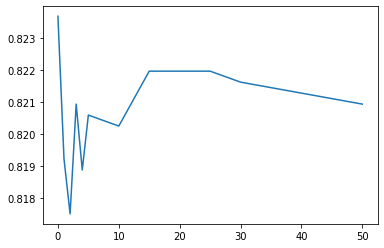

In [55]:
plt.plot(mod_k, mod_cvs)
pd.DataFrame([mod_k, mod_cvs], index = ["K", "Accuracy"])

### 4. Generating imputed features dataframe

Using the best performing value of k from the above, I run KNN imputation for the full dataset for use in further analysis, generating both imputed values and missingness indicators for subsequent analyses.

In [52]:
if not path.exists('../data/features_imputed.csv'):
    
    # Extracting meaningful predictor variables for imputation
    phy_preds = features_std[["Genus", "Family", "Order"]]
    x_preds = features_std.drop(["SpecCode", "Genus","Species", "Family", 
                           "Order", "Class", "Red List status", "Speccode"],
                          axis = 1)
    phy_dummies = pd.get_dummies(phy_preds).to_numpy()
    x_impute = np.append(phy_dummies, x_preds, axis = 1)
    
    # Running imputer
    imputer = KNNImputer(n_neighbors = 15, add_indicator=True)
    new_x = imputer.fit_transform(x_impute)[:,phy_dummies.shape[1]:]
    
    # Writing new dataframe
    full_imputed = pd.DataFrame(new_x)
    full_imputed.columns = imputed_cols
    full_imputed.to_csv('../data/features_imputed.csv')

In [60]:
full_imputed.head()

,GameFish,Imp_commercial,Imp_highly commercial,Imp_minor commercial,Imp_of no interest,Imp_of potential interest,Imp_subsistence fisheries,Aquarium_commercial,Aquarium_highly commercial,Aquarium_never/rarely,...,saltwaterMissing,brackishMissing,tropicalMissing,subtropicalMissing,polarMissing,temperateMissing,borealMissing,LengthMissing,DietTLuMissing,AreaMissing
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
